## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
!aws s3 cp s3://ebscomlaibank/BankFraudRAWData.csv .

download: s3://ebscomlaibank/BankFraudRAWData.csv to ./BankFraudRAWData.csv


In [21]:
!aws s3 cp s3://ebscomlaibank/banking-fraud-Hours.csv .

download: s3://ebscomlaibank/banking-fraud-Hours.csv to ./banking-fraud-Hours.csv


In [2]:
bucket = 'ebscomlaibank'
prefix = 'sagemaker/ebsco-banking-training'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

---
## Data


In [4]:
raw_data = pd.read_csv('./BankFraudRAWData.csv')
pd.set_option('display.max_columns', 500)
raw_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Read in data with time (step) split into hour of the day

In [23]:
raw_data = pd.read_csv('./banking-fraud-Hours.csv')
pd.set_option('display.max_columns', 500)
raw_data.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Hour
0,1,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1
1,2,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1
2,3,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1
3,4,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1
4,5,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1


In [60]:
model_data = raw_data.drop(columns=["Unnamed: 0"], axis=1)
model_data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Hour
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,23
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,23
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,23
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,23
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0,23


In [61]:
model_data = model_data.drop(columns=["step"], axis=1)
model_data.tail()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Hour
6362615,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,23
6362616,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,23
6362617,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,23
6362618,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,23
6362619,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0,23


In [36]:
model_data = model_data.drop("isFlaggedFraud", axis=1)
model_data.tail()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,Hour
6362615,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,23
6362616,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,23
6362617,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,23
6362618,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,23
6362619,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,23


In [37]:
model_data = model_data.drop("nameOrig", axis=1)
model_data = model_data.drop("nameDest", axis=1)
model_data.tail()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Hour
6362615,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,23
6362616,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,23
6362617,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,23
6362618,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,23
6362619,CASH_OUT,850002.52,850002.52,0.0,6510099.11,7360101.63,1,23


In [38]:
model_data = pd.get_dummies(model_data, columns=["type"])
model_data.tail()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
6362615,339682.13,339682.13,0.0,0.00,339682.13,1,23,0,1,0,0,0
6362616,6311409.28,6311409.28,0.0,0.00,0.00,1,23,0,0,0,0,1
6362617,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,23,0,1,0,0,0
6362618,850002.52,850002.52,0.0,0.00,0.00,1,23,0,0,0,0,1
6362619,850002.52,850002.52,0.0,6510099.11,7360101.63,1,23,0,1,0,0,0


In [41]:
is_fraud_col = model_data['isFraud']
model_data.drop(labels=['isFraud'], axis=1,inplace = True)
model_data.insert(0, 'isFraud', is_fraud_col)
model_data.tail()

,isFraud,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
6362615,1,339682.13,339682.13,0.0,0.00,339682.13,23,0,1,0,0,0
6362616,1,6311409.28,6311409.28,0.0,0.00,0.00,23,0,0,0,0,1
6362617,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,23,0,1,0,0,0
6362618,1,850002.52,850002.52,0.0,0.00,0.00,23,0,0,0,0,1
6362619,1,850002.52,850002.52,0.0,6510099.11,7360101.63,23,0,1,0,0,0


And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [42]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [43]:
train_data.head()

,isFraud,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
4734074,0,133853.35,0.0,0.00,290239.96,424093.32,20,0,1,0,0,0
3114157,0,11753.05,358115.0,346361.95,0.00,0.00,20,0,0,0,1,0
4914186,0,3662944.04,0.0,0.00,3801547.66,7464491.70,13,0,0,0,0,1
6291553,0,94020.02,214968.0,120947.98,0.00,94020.02,16,0,1,0,0,0
4391453,0,22714.83,20626.0,0.00,0.00,0.00,9,0,0,0,1,0


In [44]:
test_data.shape

(636262, 12)

Now we'll upload these files to S3.

In [45]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [46]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [47]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [48]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-05-09 14:24:40 Starting - Starting the training job...
2019-05-09 14:24:47 Starting - Launching requested ML instances......
2019-05-09 14:25:58 Starting - Preparing the instances for training......
2019-05-09 14:27:11 Downloading - Downloading input data
2019-05-09 14:27:11 Training - Downloading the training image...
2019-05-09 14:27:27 Training - Training image download completed. Training in progress.
Arguments: train
[2019-05-09:14:27:27:INFO] Running standalone xgboost training.
[2019-05-09:14:27:27:INFO] File size need to be processed in the node: 290.17mb. Available memory size in the node: 8370.12mb
[2019-05-09:14:27:27:INFO] Determined delimiter of CSV input is ','
[14:27:27] S3DistributionType set as FullyReplicated
[14:27:29] 4453834x11 matrix with 48992174 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-05-09:14:27:29:INFO] Determined delimiter of CSV input is ','
[14:27:29] S3DistributionType set as FullyReplicated
[14:27:29] 

---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [49]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [50]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [51]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [52]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,635419,16
1,154,673


In [53]:
import numpy as np
from sklearn.metrics import roc_auc_score

roc_auc_score(test_data['isFraud'], predictions)

0.9986500825982078

In [54]:
from sklearn.metrics import f1_score

f1_score(test_data["isFraud"], np.round(predictions))

0.887862796833773

In [55]:
from sklearn.metrics import precision_score

precision_score(test_data["isFraud"], np.round(predictions))

0.97677793904209

In [56]:
from sklearn.metrics import recall_score

recall_score(test_data["isFraud"], np.round(predictions))

0.8137847642079806

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

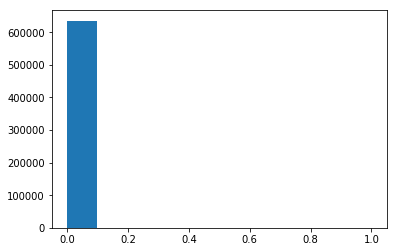

In [57]:
plt.hist(predictions)
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [58]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
isFraud,,
0,635396,39
1,131,696


In [59]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.01, 1, 0))

col_0,0,1
isFraud,,
0,632895,2540
1,3,824


We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \$100 concession. We probably could have spent that \$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

In [ ]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \$8400 by setting the cutoff to 0.46, which is substantially better than the \$20k+ I would expect to lose by not taking any action.

---

## Setup hyperparameter tuning
In this example, we are using SageMaker Python SDK to set up and manage the hyperparameter tuning job. We first configure the training jobs the hyperparameter tuning job will launch by initiating an estimator, and define the static hyperparameter and objective

In [64]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

In [62]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# sess = sagemaker.Session()

# container = get_image_uri(region, 'xgboost', repo_version='latest')

xgb = sagemaker.estimator.Estimator(
    container,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess
)

xgb.set_hyperparameters(
    eval_metric='auc',
    objective='binary:logistic',
    num_round=100,
    rate_drop=0.3,
    tweedie_variance_power=1.4
)
objective_metric_name = 'validation:auc'

# Logarithmic scaling

In both cases we use logarithmic scaling, which is the scaling type that should be used whenever the order of magnitude is more important that the absolute value. It should be used if a change, say, from 1 to 2 is expected to have a much bigger impact than a change from 100 to 101, due to the fact that the hyperparameter doubles in the first case but not in the latter.

In [65]:
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Logarithmic")
}

# Random search

We now start a tuning job using random search. The main advantage of using random search is that this allows us to train jobs with a high level of parallelism

In [66]:
tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=10,
    strategy='Random'
)

tuner_log.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [68]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

# Linear scaling

Let us compare the results with executing a job using linear scaling.

In [ ]:
hyperparameter_ranges_linear = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Linear"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Linear")
}
tuner_linear = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=20,
    max_parallel_jobs=10,
    strategy='Random'
)

# custom job name to avoid a duplicate name
job_name = tuner_log.latest_tuning_job.job_name + 'linear'
tuner_linear.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False, job_name=job_name)

Check of the hyperparameter tuning jobs status

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

## Analyze tuning job results - after tuning job is completed

**Once the tuning jobs have completed**, we can compare the distribution of the hyperparameter configurations chosen in the two cases.

Please refer to "HPO_Analyze_TuningJob_Results.ipynb" to see more example code to analyze the tuning job results.


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# check jobs have finished
status_log = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
status_linear = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

assert status_log == 'Completed', "First must be completed, was {}".format(status_log)
assert status_linear == 'Completed', "Second must be completed, was {}".format(status_linear)

df_log = sagemaker.HyperparameterTuningJobAnalytics(tuner_log.latest_tuning_job.job_name).dataframe()
df_linear = sagemaker.HyperparameterTuningJobAnalytics(tuner_linear.latest_tuning_job.job_name).dataframe()
df_log['scaling'] = 'log'
df_linear['scaling'] = 'linear'
df = pd.concat([df_log, df_linear], ignore_index=True)

In [ ]:
g = sns.FacetGrid(df, col="scaling", palette='viridis')
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.6)

## Deploy the best model
Now that we have got the best model, we can deploy it to an endpoint. Please refer to other SageMaker sample notebooks or SageMaker documentation to see how to deploy a model.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)